In [1]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import interpolate
import seaborn as sns

from MapXtremePCIC import MapXtremePCIC

In [2]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC('110m', 'eof', PATH, 'pr')
data_cube = MapXtreme.load_data
data_cube['obs'][:-1, :-1, :].values.shape

(123, 148, 35)

In [3]:
dfo_o = MapXtremePCIC.sample(data_cube, frac = 1, seed = 7, dropna = False)
dfo = dfo_o.copy().dropna()
y_g = dfo.sample(frac = 0.02)

In [ ]:
#def eof():
    

In [4]:
y_g['obs_y'] = y_g['run1'].values
df = pd.concat([y_g['obs_y'], dfo], axis=1).dropna()

y_g_arr = np.subtract(df['obs_y'], df['obs_y'].mean())

In [5]:
df['frac_area'] = df['areas']/df['areas'].sum()
dfo['frac_area'] = dfo['areas']/dfo['areas'].sum()

mean = df['obs_y'].mean()

X_arr = MapXtremePCIC.get_arr(MapXtreme, df)[2]
Xo_arr = MapXtremePCIC.get_arr(MapXtreme, dfo)[2]

Xp = np.subtract(X_arr, X_arr.mean(axis=0))
Xpo = np.subtract(Xo_arr, Xo_arr.mean(axis=0))

W = np.diag(df['frac_area'].values)
Wo = np.diag(dfo['frac_area'].values)

X = np.matmul(Xp, W)
Xo = np.matmul(Xpo, Wo)

y_w = np.matmul(y_g_arr, W)

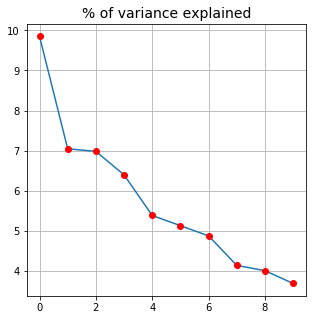

(35, 177) (28, 177)
(8843,) (35, 8843)


In [6]:
skpca = pca.PCA()
skpca.fit(X)

skpcao = pca.PCA()

f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()
plt.show()

ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.95)[0][0]

EOFs = skpca.components_

EOFs = EOFs[:ipc, :]

print(X.shape, EOFs.shape)

# reconstruct the field map
x = EOFs[0, :]
y = y_w
#print(x.shape)
f = interpolate.interp1d(x, y)

# reconstruct observed field from this interpolation
X_new = f(Xo[0, :])
print(X_new.shape, Xo.shape)

#plt.hist(np.hstack(y_g_arr))
#plt.hist(np.hstack(X_new))
#sns.distplot(np.hstack(X_new))
#sns.distplot(np.hstack(y))

In [7]:
dfo['eof'] = np.dot(X_new, Wo[0, :].T) + Xo_arr.mean(axis=0)

In [8]:
dfo['eof']

17582    1.844271
9251     5.243453
1318     3.184987
17337    2.290240
6844     1.543233
15026    2.297349
7512     6.869535
16199    2.363322
3324     7.583214
5719     5.973980
6694     5.447193
12840    3.129397
2573     3.452664
10746    3.902086
11461    4.118914
15583    3.607257
13569    2.543941
5852     6.870715
12688    3.162944
14701    3.346675
6155     5.970279
14398    3.874768
13729    2.738844
16757    2.228402
8532     4.642509
7349     5.226505
5884     7.389892
6028     7.399181
11610    3.996162
15794    2.291143
           ...   
14539    2.184599
12690    3.177915
13395    2.981763
13442    3.207674
1439     4.967824
5085     3.368828
8225     5.573994
9877     4.716161
1248     3.862547
16476    2.339433
5437     7.202193
10985    3.942927
6423     5.688585
6748     5.831866
11180    4.313166
16641    2.080203
8964     5.340504
14537    1.816507
8504     5.090862
12471    2.965031
3896     3.270834
7955     6.764447
13387    3.332118
17840    1.467350
1092     9

In [9]:
#N = np.dot(dfo['eof'].values, np.linalg.inv(Wo))

In [10]:
#N_n = (N + df['obs_y'].mean())

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

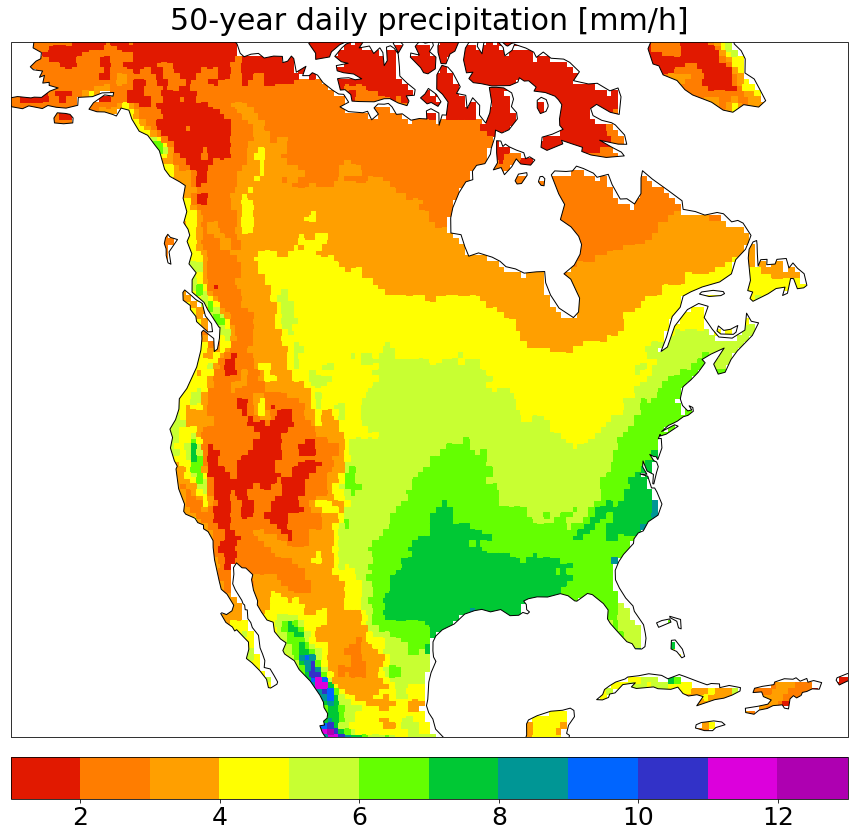

In [11]:
rp = MapXtremePCIC.rp()
ocean = MapXtremePCIC.ocean_mask('110m')
cmap = MapXtremePCIC.color_pallette()

plt.figure(figsize = (15, 15))

rlon = dfo['rlon']
rlat = dfo['rlat']
N = dfo['eof']

# define projections
ax = plt.axes(projection=rp)#ccrs.PlateCarree())
ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
colorplot = ax.scatter(rlon, rlat, c = N, marker='s', cmap=cmap, vmin=1., vmax=13.)
cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)
cbar.ax.tick_params(labelsize=25)

# constrain to data
plt.xlim(rlon.min(), rlon.max())
plt.ylim(rlat.min(), rlat.max())

# return/undo the supress invalid warning
np.seterr(invalid = 'warn')

In [12]:
#dfo_fine = dfo[['rlat', 'rlon', 'eof']].sort_values(by=['rlat', 'rlon']).copy()

In [13]:
from scipy.signal import resample
import scipy.misc

dfo_resampled = pd.DataFrame()


dlon = np.diff(dfo['rlon'].sort_values()).mean()
dlat = np.diff(dfo['rlat'].sort_values()).mean()

df_to_reshape = pd.concat([dfo_o, dfo], axis=1)
df_to_reshape['eof'].shape
#dfo_resampled['rlat'] = np.tile(dfo_fine['rlat'].values, 100)
#dfo_resampled['rlon'] = np.repeat(dfo_fine['rlon'].values, 100)

#N = dfo_fine['rlat'].shape[0]*100

#rlat_resampled = resample(dfo_fine['rlat'].values, N)
#rlon_resampled = resample(dfo_fine['rlon'].values, N)

(18204,)

In [14]:
xx = data_cube['rlat'].shape[0]-1
yy = data_cube['rlon'].shape[0]-1

xlon = data_cube['rlon'][:-1].values
ylat = data_cube['rlat'][:-1].values
#dfo_resampled_new = pd.concat([dfo_fine, dfo_resampled])
#y_eof = dfo_resampled_new['eof'].dropna()

In [15]:
#dfo_resampled['rlat'] = np.tile(dfo_fine['rlat'].values, 100)
#dfo_resampled['rlon'] = np.tile(dfo_fine['rlon'].values, 100)

In [16]:
eof_arr = np.reshape(df_to_reshape['eof'].values, (xx, yy))

In [17]:
#f2d_interp = interpolate.griddata((xlon, ylat), eof_arr, method='linear')

In [25]:
N = 20
n = np.linspace(-N/2, N/2, N+1)
xlon_up = np.ones((xlon.shape[0], N+1))
ylat_up = np.ones((ylat.shape[0], N+1))

xlon_diff = np.diff(np.sort(xlon)).mean()
ylat_diff = np.diff(np.sort(ylat)).mean()

dx = n*(xlon_diff/N)
dy = n*(ylat_diff/N)

print(xlon_up.shape)

for i in range(xlon_up.shape[0]):
    xlon_up[i, :] = xlon[i] + xlon[i]*dx
    
for i in range(ylat_up.shape[0]):
    ylat_up[i, :] = ylat[i] + ylat[i]*dy

rlon_up = np.reshape(xlon_up, (xlon_up.shape[0]*xlon_up.shape[1])) 
rlat_up = np.reshape(ylat_up, (ylat_up.shape[0]*ylat_up.shape[1]))

rlat_upp = np.tile(rlon_up, rlat_up.shape[0])
rlon_upp = np.repeat(rlat_up, rlon_up.shape[0])

rlat = np.tile(xlon, ylat.shape[0])
rlon = np.repeat(ylat, xlon.shape[0])
    
print(rlon_up, rlat_up)

z = eof_arr

grid_x, grid_y = np.meshgrid(rlon_up, rlat_up)
points = np.asarray(list(zip(rlon, rlat)))

print(points.shape)

f2d_interp = interpolate.griddata(points, z, (grid_x, grid_y), method='linear')
#eof_interp = f2d_interp(rlon_up, rlat_up)
#eof_interp

(148, 21)
[-25.39680912 -26.11312949 -26.82944986 ...  37.77311495  38.47975493
  39.18639491] [-21.27839901 -21.87855899 -22.47871897 ...  31.04640182  31.62720186
  32.20800189]
(18204, 2)


ValueError: different number of values and points

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/numpy/ma/core.py:718: UserW

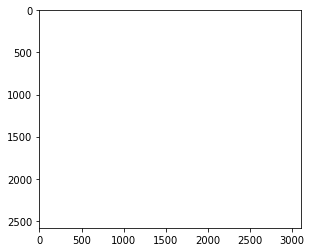

In [35]:
plt.imshow(eof_interp)

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/numpy/ma/core.py:718: UserW

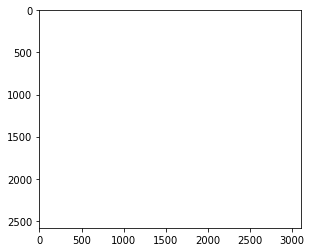

In [23]:
np.seterr(invalid = 'ignore')

data_cube = MapXtreme.load_data
res = MapXtreme.res

# take mean of all simulation runs
N = eof_interp

# custom colormap
cmap = MapXtremePCIC.color_pallette()

# ocean mask
ocean = MapXtremePCIC.ocean_mask(res)

# custom ax object with projection
rp = MapXtremePCIC.rp()

#plt.figure(figsize = (15, 15))

# define projections
#ax = plt.axes(projection = rp)
#ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
#ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
#colorplot = plt.pcolormesh(rlon_up, rlat_up, N, transform=rp, cmap=cmap, vmin=1., vmax=13.)
plt.imshow(N)
cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)
cbar.ax.tick_params(labelsize=25)

In [ ]:
#plt.imshow(res, transform=rp)

12300


MemoryError: 

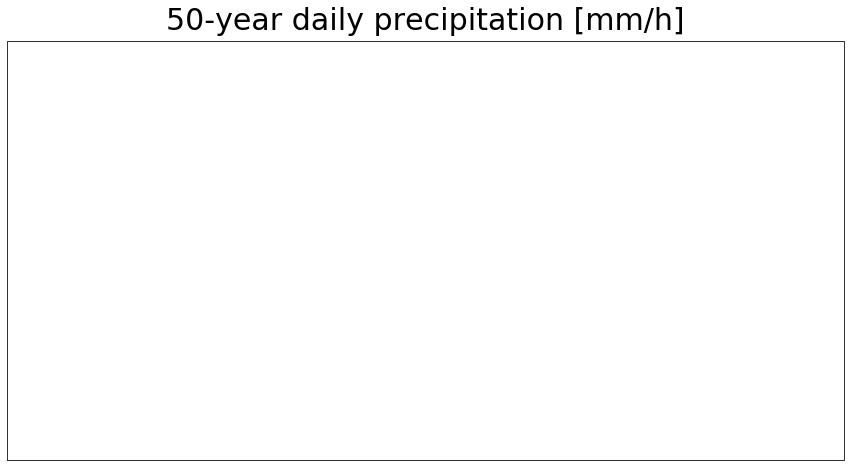

In [28]:
rp = MapXtremePCIC.rp()
ocean = MapXtremePCIC.ocean_mask('110m')
cmap = MapXtremePCIC.color_pallette()

plt.figure(figsize = (15, 15))

rlon = dfo['rlon']
rlat = dfo['rlat']
N = dfo['eof']

# define projections
ax = plt.axes(projection=rp)#ccrs.PlateCarree())
ax.set_title('50-year daily precipitation [mm/h]', fontsize=30, verticalalignment='bottom')
#ax.add_feature(ocean, zorder=2)

# plot design values with custom colormap
#colorplot = ax.scatter(rlon, rlat, c = N, marker='s', cmap=cmap, vmin=1., vmax=13.)
#cbar = plt.colorbar(colorplot, ax=ax, orientation="horizontal", fraction=0.07, pad=0.025)

ax.imshow(res, transform=rp)
ax.invert_yaxis()

cbar.ax.tick_params(labelsize=25)

# constrain to data
plt.xlim(rlon.min(), rlon.max())
plt.ylim(rlat.min(), rlat.max())

# return/undo the supress invalid warning
np.seterr(invalid = 'warn')